# IMPORTS

In [21]:
!pip install inflection

In [22]:
import inflection 

In [23]:
import math
import numpy  as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## Helper Functions

In [24]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [25]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [26]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# DESCRICAO DOS DADOS

In [27]:
df1 = df_raw.copy()

## Rename Columns

In [28]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## Data Dimensions

In [29]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## Data Types

In [30]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [31]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [32]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
768390,941,1,2013-08-12,8083,786,1,1,0,1,a,a,1200.0,12.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [33]:
#competition_distance        
df1['competition_distance'].fillna(100000., inplace=True)

In [34]:
#competition_open_since_month
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

In [35]:
#competition_open_since_year 
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

In [36]:
#promo2_since_week           
df1.promo2_since_week.fillna(df1.date.dt.week, inplace=True)

In [37]:
#promo2_since_year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

In [38]:
# substitui os 0 para '', assim não será necessário um dos if's do is_promo
df1['promo_interval'].replace(0, '', inplace=True)
df1['promo_interval'].fillna('', inplace=True) 

In [39]:
df1['promo_interval'].fillna(0, inplace=True )

In [40]:
df1['date'].dt.strftime("%b").value_counts() 

Mar    103695
May    103695
Jan    103694
Jun    100350
Apr    100350
Jul     98115
Feb     93660
Oct     63550
Dec     63550
Aug     63550
Sep     61500
Nov     61500
Name: date, dtype: int64

In [41]:
df1['month_map'] = df1['date'].dt.strftime("%b")  # df1['date'].dt.month.map( month_map )

In [43]:
# como não tem 0's mais, tudo vai ser string, então podemos remover aqueles if's
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: x['month_map'] in x['promo_interval'].split( ',' ), axis='columns').astype('int')

# df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [44]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Data Types

In [45]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistics

In [46]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [49]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2
547270,591,3,5093,515,1,0,0,3340.0,1
1011875,241,6,5837,664,1,0,0,780.0,0
641884,430,2,10515,772,1,1,0,12870.0,0
875703,99,2,3399,375,1,0,0,2030.0,1
362624,23,1,8233,659,1,1,1,4060.0,0


In [50]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
860024,0,a,a,2,2014,10,2014,"Mar,Jun,Sept,Dec",May,0
400618,0,d,a,3,2014,28,2014,,Jul,0
323899,0,a,a,9,2012,40,2014,,Sep,0
688097,0,d,c,10,2013,31,2013,"Feb,May,Aug,Nov",Oct,0
253290,0,a,a,10,2014,50,2014,,Dec,0


### 1.7.1. Numerical Atributes

In [51]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999


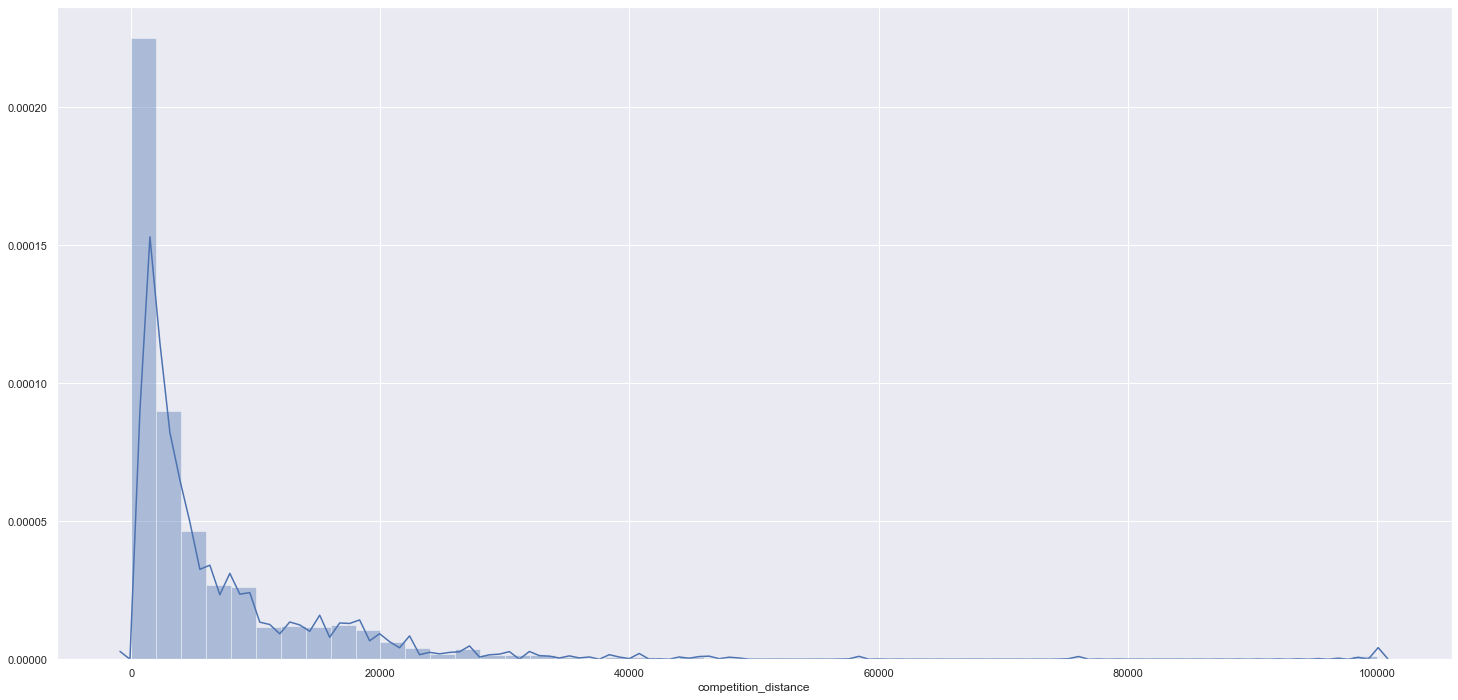

In [53]:
sns.distplot( df1['competition_distance'], kde=True )

### 1.7.2. Categorical Atributes

In [54]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
is_promo                         2
dtype: int64

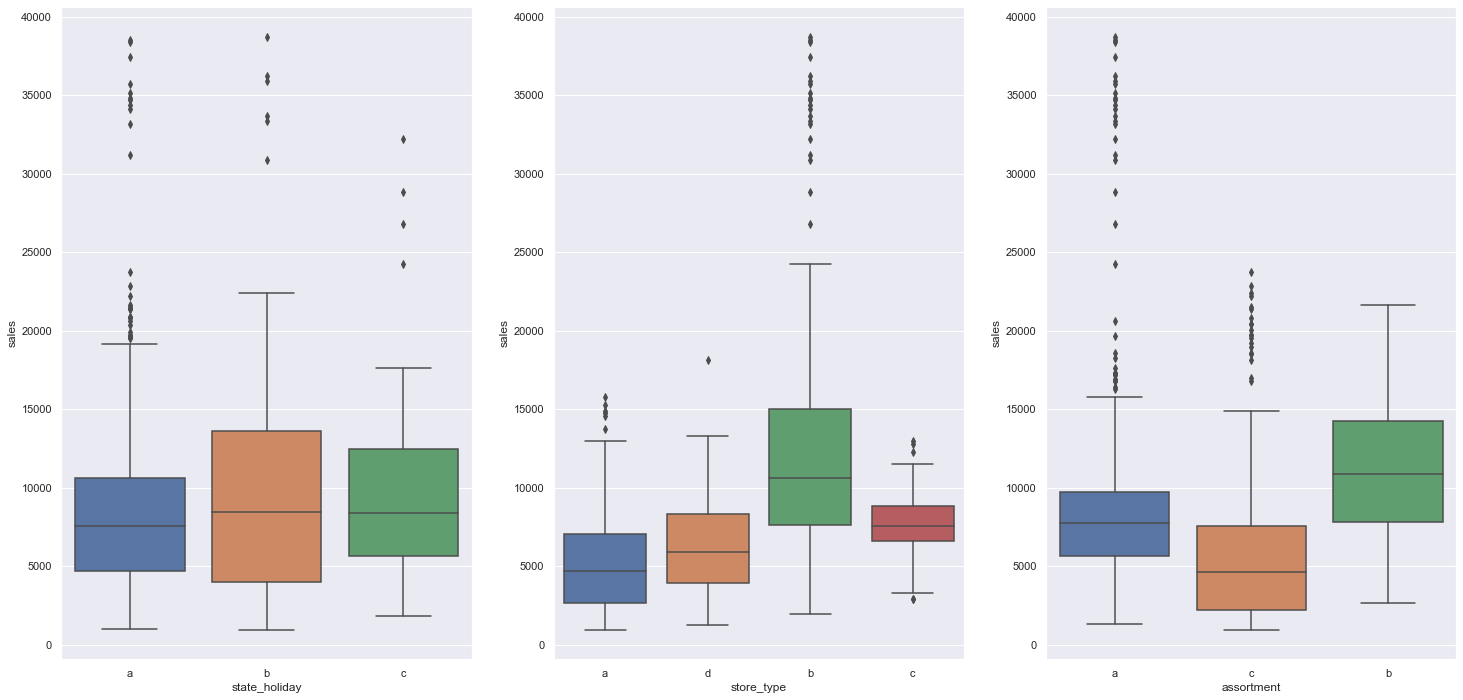

In [55]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )